In [1]:
import json
import pickle
import numpy as np
import os.path as op
import itertools as it
from utilities import files
import matplotlib.pylab as plt
from joblib import Parallel, delayed
from tqdm.notebook import trange, tqdm
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
from scipy.ndimage import gaussian_filter, gaussian_filter1d
from extra.tools import many_is_in, cat, shuffle_array, shuffle_array_range, consecutive_margin_ix, dump_the_dict

In [15]:
waveform_subset_path = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/waveforms_clean_subset_fit.npy"
scaler_path = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/scaler_MEG.pkl"
PCA_path = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/pca_solution_MEG.pkl"
dataset = "/home/mszul/datasets/explicit_implicit_beta/derivatives/PCA_results/sub_metrics.pkl"

In [16]:
waveforms_clean = np.load(waveform_subset_path)
scaler_meg = pickle.load(open(scaler_path, "rb"))
PCA_saved = pickle.load(open(PCA_path, "rb"))
sub_metrics = pickle.load(open(dataset, "rb"))

In [4]:
burst_times = np.linspace(-0.13, 0.13, num=156)
mean_waveform = np.mean(waveforms_clean, axis=0)
norm_waveform = mean_waveform / mean_waveform.max()

Text(0, 0.5, 'fT')

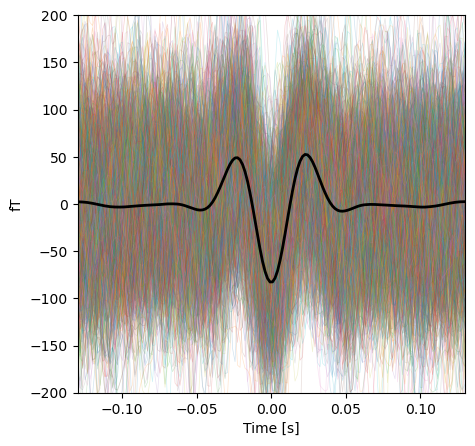

In [5]:
f, ax = plt.subplots(1, 1, figsize=(5,5), dpi=100, facecolor="white")
ax.plot(burst_times, waveforms_clean[:1000,:].T / 1e-15, rasterized=True, lw=0.5, alpha=0.2)
ax.plot(burst_times, mean_waveform / 1e-15, lw=2, color="black")
ax.set_xlim(burst_times[0], burst_times[-1])
ax.set_ylim(-200, 200)
ax.set_xlabel("Time [s]")
ax.set_ylabel("fT")

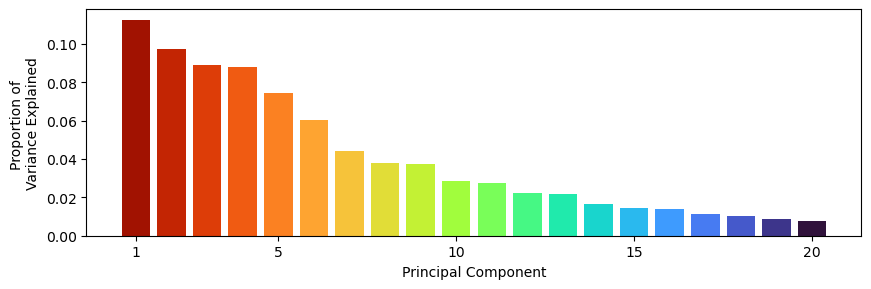

In [6]:
f, ax = plt.subplots(1, 1, figsize=(10,3), dpi=100, facecolor="white")
PC_var_exp = PCA_saved.explained_variance_ratio_
PC_r = np.arange(PC_var_exp.shape[0]) + 1
bar = ax.bar(PC_r, PC_var_exp, lw=0.2)
cm = plt.cm.get_cmap("turbo_r")
for i in PC_r:
    plt.setp(bar[i-1],"facecolor", cm(i/20))
ax.set_xlabel("Principal Component")
ax.set_ylabel("Proportion of \nVariance Explained")
# ax.axvline(PCS_to_analyse+0.45, linestyle="dashed", c="red", lw=0.5)
ax.set_xticks([1, 5, 10, 15, 20]);

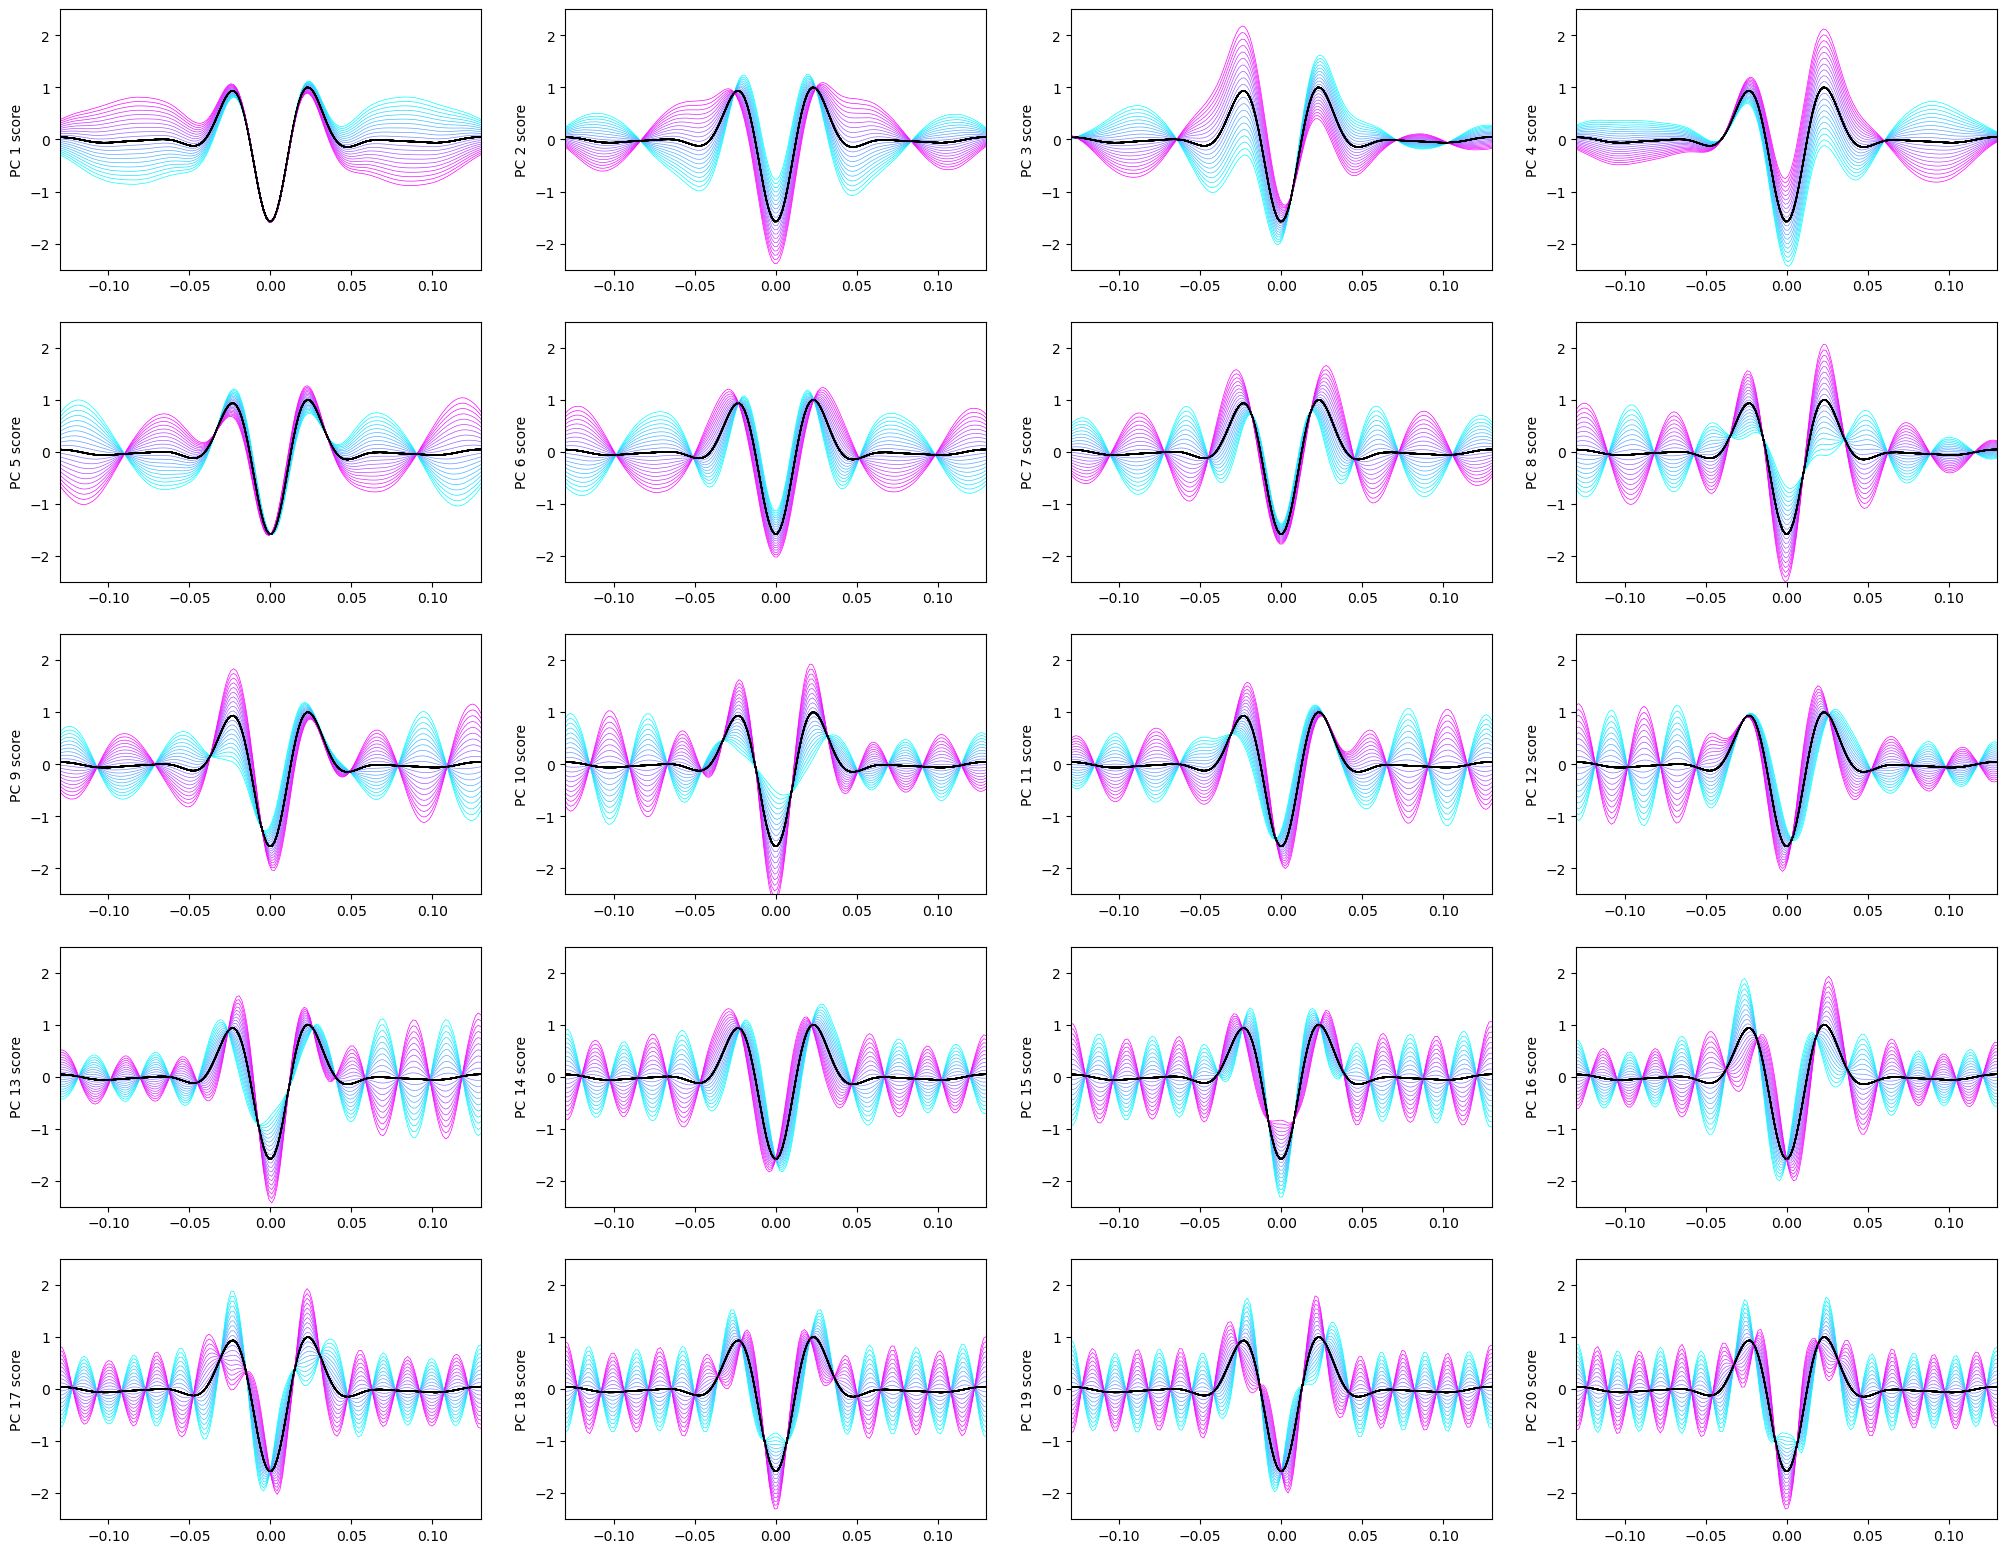

In [7]:
score_range = np.linspace(-7, 7, num=21)
colour_range = plt.cm.cool(np.linspace(0, 1, num=score_range.shape[0]))

f, ax = plt.subplots(5, 4, figsize=(25, 20), facecolor="white", dpi=100)
for pc_ix, (row, col) in enumerate(list(it.product(range(5), range(4)))):
    for sc_ix, score_r in enumerate(score_range):
        ax[row, col].plot(
            burst_times,
            norm_waveform + score_r * PCA_saved.components_[pc_ix,:], 
            color=colour_range[sc_ix], lw=0.5)
        ax[row, col].plot(burst_times, norm_waveform, lw=1, color="black")
    ax[row, col].set_ylabel("PC {} score".format(pc_ix + 1))
    ax[row, col].set_ylim(-2.5, 2.5)
    ax[row, col].set_xlim(-0.13, 0.13)

In [8]:
shuff_range = np.linspace(8, 148, 7, endpoint=False).astype(int)
shuff_range = np.insert(shuff_range, 0, 0)
shuff_range = np.append(shuff_range, 156)
shuff_range = list(zip(shuff_range[:-1], shuff_range[1:]))

iter_no = 100
pca_vars = []

waveform_scaled = scaler_meg.transform(waveforms_clean)

# for i in trange(iter_no):
#     np.random.seed()
#     shuffled_waveforms = shuffle_array_range(waveform_scaled, shuff_range)
#     pca_shuff = PCA(n_components=20)
#     pca_shuff.fit(shuffled_waveforms)
#     pca_vars.append(pca_shuff.explained_variance_ratio_)
#     del shuffled_waveforms

# def par_job_pca(waveform_scaled, shuff_range):
#     np.random.seed()
#     shuffled_waveforms = shuffle_array_range(waveform_scaled, shuff_range)
#     pca_shuff = PCA(n_components=20)
#     pca_shuff.fit(shuffled_waveforms)
#     pca_vars.append(pca_shuff.explained_variance_ratio_)
#     del shuffled_waveforms

# Parallel(n_jobs=10, require="sharedmem")(delayed(par_job_pca)(waveform_scaled, shuff_range) for i in trange(iter_no))

In [19]:
all_waveforms = []
for sub in tqdm(sub_metrics.keys()):
    all_waveforms.append(sub_metrics[sub]["vis"]["waveform"])
    all_waveforms.append(sub_metrics[sub]["mot"]["waveform"])
all_waveforms = np.vstack(all_waveforms)
all_waveforms_scores = PCA_saved.transform(scaler_meg.transform(all_waveforms))

gkeys = ['peak_time', 'peak_freq', 'peak_amp_base', 'fwhm_freq', 'fwhm_time']
all_metrics = {i: [] for i in gkeys}

for sub in tqdm(sub_metrics.keys()):
    for k in gkeys:
        all_metrics[k].append(sub_metrics[sub]["vis"][k])
        all_metrics[k].append(sub_metrics[sub]["mot"][k])
for k in gkeys:
    all_metrics[k] = np.hstack(all_metrics[k]).flatten()

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

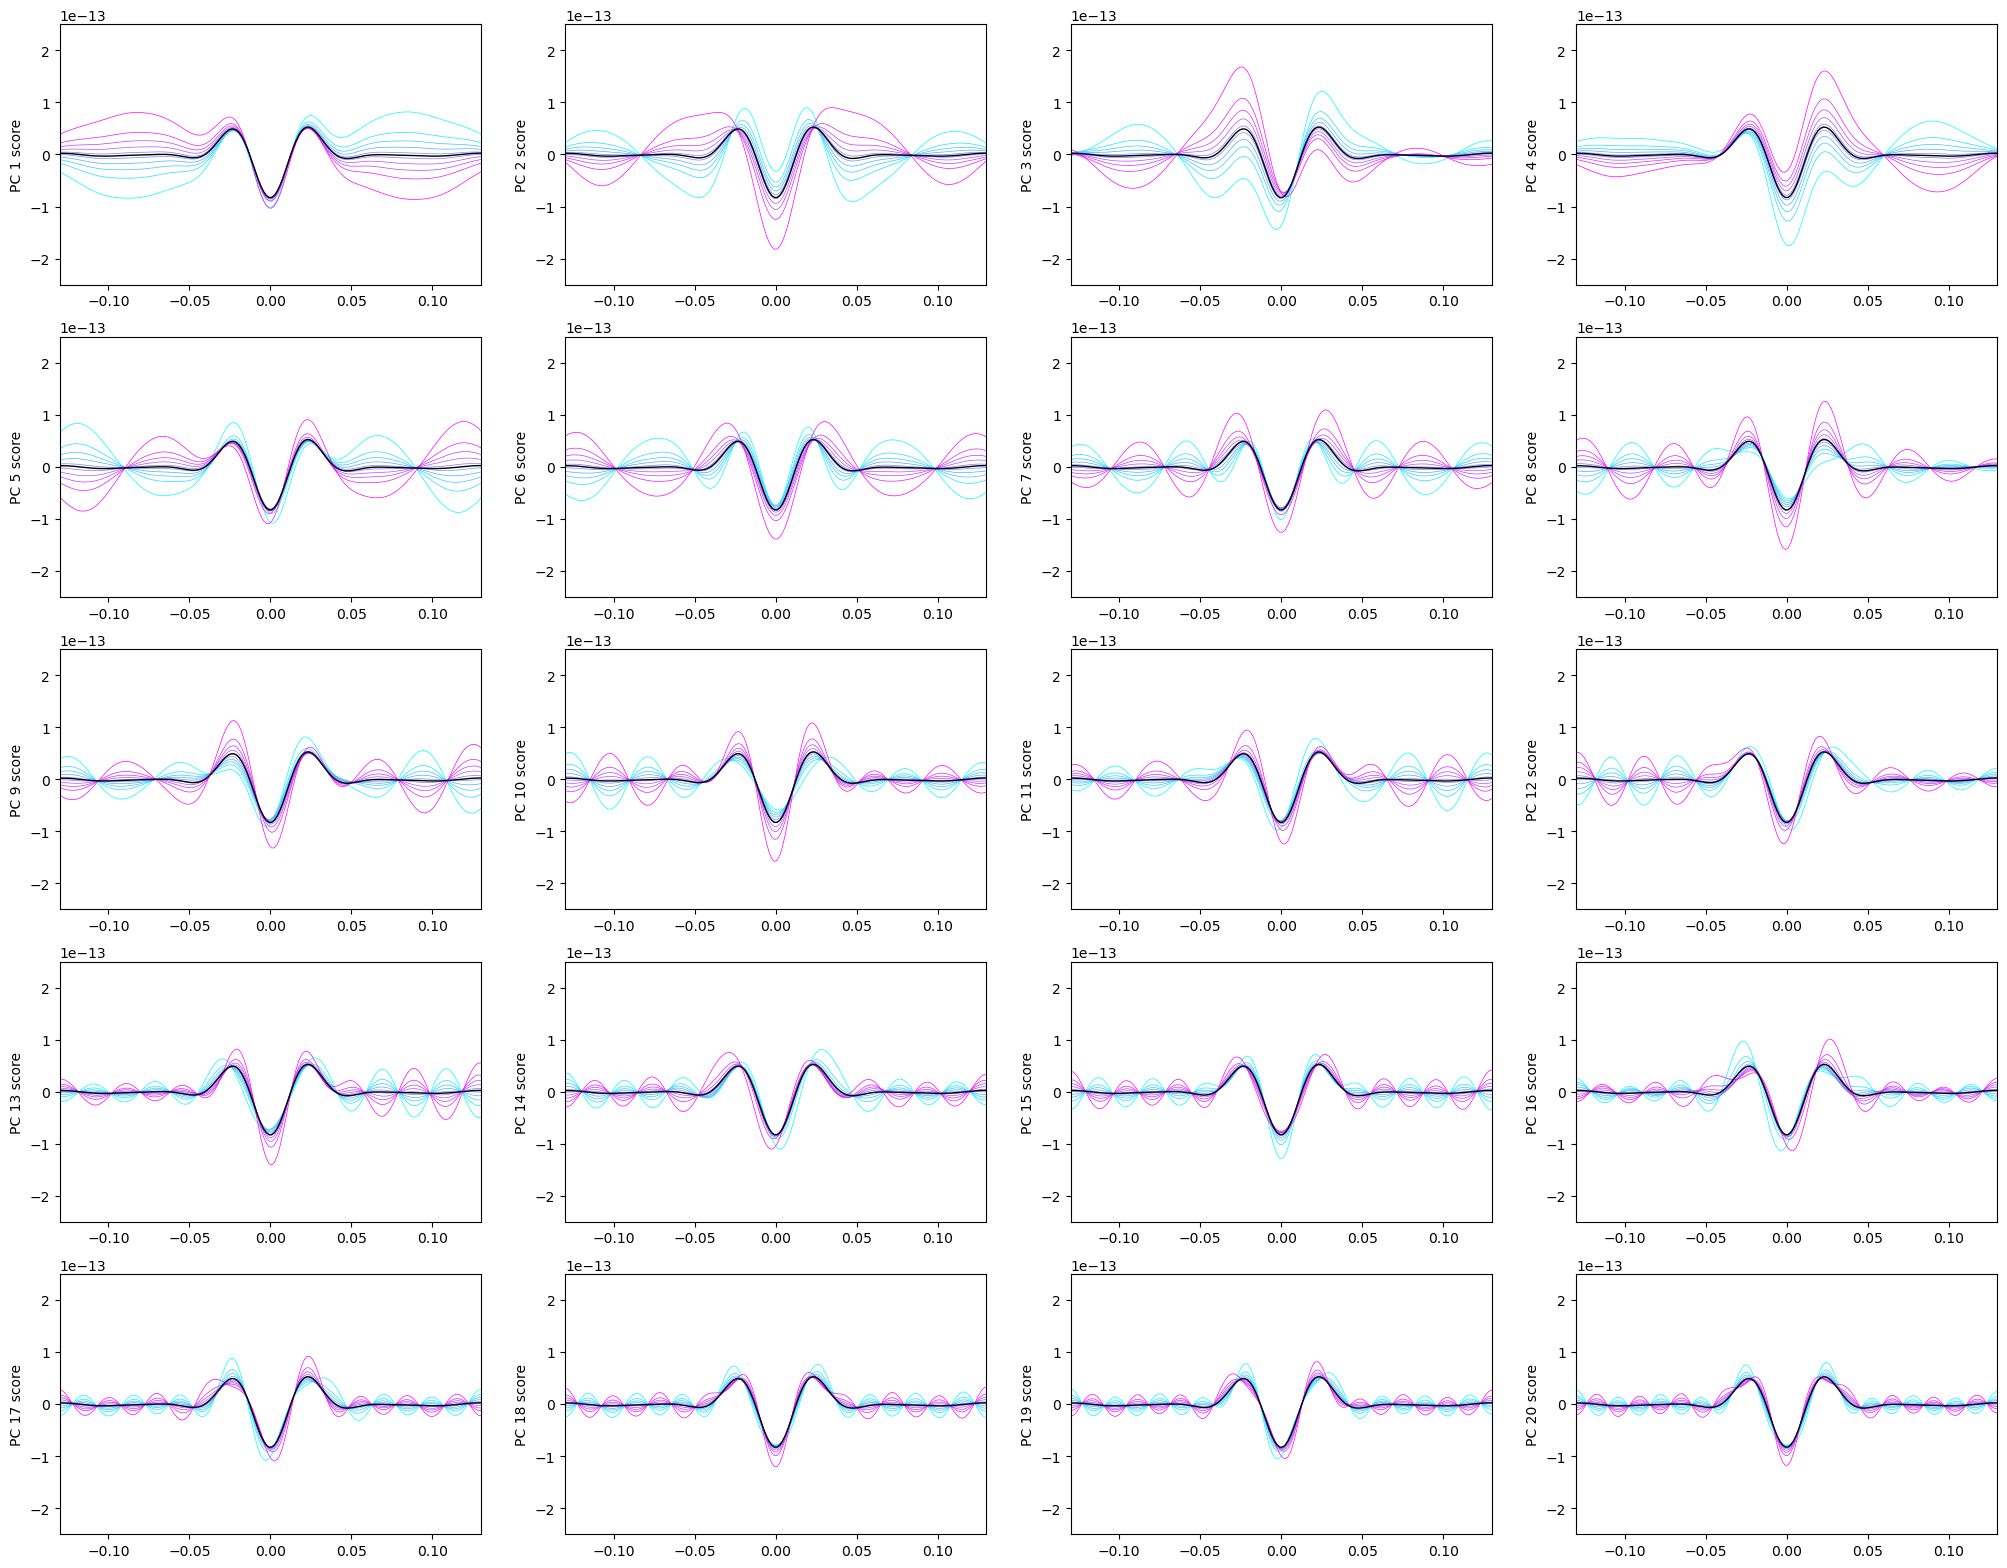

In [50]:
r_t = np.arange(0,101, 10)
ranges_10 = list(zip(r_t[:-1], r_t[1:]))
shape_range = plt.cm.cool(np.linspace(0, 1, num=len(ranges_10)))

f, ax = plt.subplots(5, 4, figsize=(25, 20), facecolor="white", dpi=100)
for pc_ix, (row, col) in enumerate(list(it.product(range(5), range(4)))):
    for range_ix, (low_v, up_v) in enumerate(ranges_10):
        low_perc = np.percentile(all_waveforms_scores[:, pc_ix], low_v)
        up_perc = np.percentile(all_waveforms_scores[:, pc_ix], up_v)
        perc_ixs = np.where(
            (all_waveforms_scores[:, pc_ix] >= low_perc) & 
            (all_waveforms_scores[:, pc_ix] <= up_perc)
        )[0]
        perc_mean = np.mean(all_waveforms[perc_ixs, :], axis=0)
        ax[row, col].plot(
            burst_times,
            perc_mean,
            lw=0.5,
            c=shape_range[range_ix],
            label="{}-{}$^(th)$".format(low_v, up_v)
        )
        
    ax[row, col].plot(
        burst_times,
        mean_waveform,
        lw=1,
        c="black"
    )
    ax[row, col].set_ylabel("PC {} score".format(pc_ix + 1))
    ax[row, col].set_ylim(-2.5*1e-13, 2.5*1e-13)
    ax[row, col].set_xlim(-0.13, 0.13)